In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from tqdm.auto import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load dataset
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/6004/project 2/code'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Settings



In [91]:
class icuDataset(Dataset):
  def __init__(self, x, y):
    super(icuDataset, self).__init__()
    # store the raw tensors
    self._x = x
    self._y = y

  def __len__(self):
    # size of Dataset
    return self._x.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    x = self._x[idx, :]
    y = self._y[idx]
    return x, y

In [92]:
def save_checkpoints(encoder, decoder, opt, checkpoint_path):
    save_dict = {}
    save_dict.update({'encoder': encoder.state_dict()})
    save_dict.update({'decoder': decoder.state_dict()})
    save_dict.update({'opt': opt.state_dict()})
    torch.save(save_dict, checkpoint_path)

def load_checkpoints(encoder, decoder, opt, checkpoint_path):
    ckpt = torch.load(checkpoint_path)
    encoder.load_state_dict(ckpt['encoder'])
    decoder.load_state_dict(ckpt['decoder'])
    opt.load_state_dict(ckpt['opt'])

In [93]:
# parameters

# datasets after preprocessing
file_path = '/content/drive/My Drive/6004/project2/code/clean_regress_id.csv'
data_2 = pd.read_csv(file_path)

# pre-defined global parameters
seed = 123
device = "cuda" if torch.cuda.is_available() else "cpu"

log_dir = 'models/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# set seeds
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


## ICU duration (continuous) without death/discharge classification

In [94]:
y0 = torch.tensor(data_2['los_icu'], dtype = torch.float32)
X0 = torch.tensor(data_2.iloc[:, 2:].values, dtype = torch.float32)
# Verify the shapes
print("Shapes of X0 and y0:", X0.shape, y0.shape)


Shapes of X0 and y0: torch.Size([19199, 66]) torch.Size([19199])


In [95]:

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size = 0.2, random_state = seed)

train_data_0 = icuDataset(X0_train, y0_train)
test_data_0 = icuDataset(X0_test, y0_test)

train_loader_0 = DataLoader(train_data_0, batch_size = 128, shuffle = True)
test_loader_0 = DataLoader(test_data_0, batch_size = 128, shuffle = False)

### Neural network (FC)

In [48]:
class BaseRegressor(nn.Module):
    def __init__(self):
        super(BaseRegressor, self).__init__()
        self.fc_b1 = nn.Linear(66, 32)
        self.fc_b2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc_b1(x))
        x = F.relu(self.fc_b2(x))
        return x

In [49]:
br = BaseRegressor().to(device)

# loss function
loss_func = torch.nn.MSELoss()

# optimizer
opt = optim.SGD(list(br.parameters()), lr = 0.0001, momentum = 0.9, weight_decay = 5e-4)

In [50]:

num_epochs = 200  # Set the number of epochs to 200
br_train_loss = []  # Initialize a list to store loss for each epoch

for epoch in range(1, num_epochs + 1):
    br.train()  # Set the model to training mode
    loss_list = []  # List to store losses for each batch in the current epoch

    for x, y in tqdm(train_loader_0, desc=f"Training Epoch #{epoch}"):
        x, y = x.to(device), y.to(device)  # Ensure data is on the correct device

        opt.zero_grad()  # Zero the gradients to prevent accumulation
        pred = br(x)  # Forward pass: compute predictions
        loss = loss_func(pred.squeeze(), y)  # Calculate loss; ensure dimensions match

        loss.backward()  # Backpropagate the errors
        opt.step()  # Update model parameters

        loss_list.append(loss.item())  # Append the loss for this batch to the list

    # Compute the average loss for this epoch
    epoch_loss = sum(loss_list) / len(loss_list)
    br_train_loss.append(epoch_loss)  # Append average loss to the training loss list

    # Print the average loss for the epoch
    print(f"Epoch {epoch}: Avg Loss = {epoch_loss:.4f}")


Training Epoch #1:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1: Avg Loss = 15.4746


Training Epoch #2:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2: Avg Loss = 8.6071


Training Epoch #3:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3: Avg Loss = 7.9638


Training Epoch #4:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4: Avg Loss = 7.8514


Training Epoch #5:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5: Avg Loss = 7.7966


Training Epoch #6:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6: Avg Loss = 7.7626


Training Epoch #7:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7: Avg Loss = 7.7364


Training Epoch #8:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8: Avg Loss = 7.7138


Training Epoch #9:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9: Avg Loss = 7.6970


Training Epoch #10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10: Avg Loss = 7.6804


Training Epoch #11:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 11: Avg Loss = 7.6675


Training Epoch #12:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 12: Avg Loss = 7.6544


Training Epoch #13:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 13: Avg Loss = 7.6439


Training Epoch #14:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 14: Avg Loss = 7.6325


Training Epoch #15:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 15: Avg Loss = 7.6239


Training Epoch #16:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 16: Avg Loss = 7.6152


Training Epoch #17:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 17: Avg Loss = 7.6073


Training Epoch #18:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 18: Avg Loss = 7.5992


Training Epoch #19:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 19: Avg Loss = 7.5924


Training Epoch #20:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 20: Avg Loss = 7.5861


Training Epoch #21:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 21: Avg Loss = 7.5790


Training Epoch #22:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 22: Avg Loss = 7.5731


Training Epoch #23:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 23: Avg Loss = 7.5678


Training Epoch #24:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 24: Avg Loss = 7.5624


Training Epoch #25:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 25: Avg Loss = 7.5571


Training Epoch #26:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 26: Avg Loss = 7.5536


Training Epoch #27:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 27: Avg Loss = 7.5487


Training Epoch #28:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 28: Avg Loss = 7.5454


Training Epoch #29:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 29: Avg Loss = 7.5403


Training Epoch #30:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 30: Avg Loss = 7.5365


Training Epoch #31:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 31: Avg Loss = 7.5332


Training Epoch #32:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 32: Avg Loss = 7.5298


Training Epoch #33:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 33: Avg Loss = 7.5251


Training Epoch #34:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 34: Avg Loss = 7.5229


Training Epoch #35:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 35: Avg Loss = 7.5211


Training Epoch #36:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 36: Avg Loss = 7.5173


Training Epoch #37:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 37: Avg Loss = 7.5137


Training Epoch #38:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 38: Avg Loss = 7.5110


Training Epoch #39:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 39: Avg Loss = 7.5096


Training Epoch #40:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 40: Avg Loss = 7.5071


Training Epoch #41:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 41: Avg Loss = 7.5030


Training Epoch #42:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 42: Avg Loss = 7.5004


Training Epoch #43:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 43: Avg Loss = 7.4995


Training Epoch #44:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 44: Avg Loss = 7.4966


Training Epoch #45:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 45: Avg Loss = 7.4931


Training Epoch #46:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 46: Avg Loss = 7.4909


Training Epoch #47:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 47: Avg Loss = 7.4883


Training Epoch #48:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 48: Avg Loss = 7.4866


Training Epoch #49:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 49: Avg Loss = 7.4841


Training Epoch #50:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 50: Avg Loss = 7.4822


Training Epoch #51:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 51: Avg Loss = 7.4803


Training Epoch #52:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 52: Avg Loss = 7.4787


Training Epoch #53:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 53: Avg Loss = 7.4754


Training Epoch #54:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 54: Avg Loss = 7.4733


Training Epoch #55:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 55: Avg Loss = 7.4713


Training Epoch #56:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 56: Avg Loss = 7.4681


Training Epoch #57:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 57: Avg Loss = 7.4663


Training Epoch #58:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 58: Avg Loss = 7.4651


Training Epoch #59:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 59: Avg Loss = 7.4623


Training Epoch #60:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 60: Avg Loss = 7.4598


Training Epoch #61:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 61: Avg Loss = 7.4584


Training Epoch #62:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 62: Avg Loss = 7.4548


Training Epoch #63:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 63: Avg Loss = 7.4529


Training Epoch #64:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 64: Avg Loss = 7.4517


Training Epoch #65:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 65: Avg Loss = 7.4492


Training Epoch #66:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 66: Avg Loss = 7.4486


Training Epoch #67:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 67: Avg Loss = 7.4451


Training Epoch #68:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 68: Avg Loss = 7.4436


Training Epoch #69:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 69: Avg Loss = 7.4395


Training Epoch #70:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 70: Avg Loss = 7.4396


Training Epoch #71:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 71: Avg Loss = 7.4371


Training Epoch #72:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 72: Avg Loss = 7.4355


Training Epoch #73:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 73: Avg Loss = 7.4339


Training Epoch #74:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 74: Avg Loss = 7.4317


Training Epoch #75:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 75: Avg Loss = 7.4296


Training Epoch #76:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 76: Avg Loss = 7.4280


Training Epoch #77:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 77: Avg Loss = 7.4253


Training Epoch #78:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 78: Avg Loss = 7.4240


Training Epoch #79:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 79: Avg Loss = 7.4218


Training Epoch #80:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 80: Avg Loss = 7.4197


Training Epoch #81:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 81: Avg Loss = 7.4177


Training Epoch #82:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 82: Avg Loss = 7.4155


Training Epoch #83:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 83: Avg Loss = 7.4135


Training Epoch #84:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 84: Avg Loss = 7.4113


Training Epoch #85:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 85: Avg Loss = 7.4096


Training Epoch #86:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 86: Avg Loss = 7.4073


Training Epoch #87:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 87: Avg Loss = 7.4050


Training Epoch #88:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 88: Avg Loss = 7.4032


Training Epoch #89:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 89: Avg Loss = 7.4019


Training Epoch #90:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 90: Avg Loss = 7.3988


Training Epoch #91:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 91: Avg Loss = 7.3961


Training Epoch #92:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 92: Avg Loss = 7.3946


Training Epoch #93:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 93: Avg Loss = 7.3930


Training Epoch #94:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 94: Avg Loss = 7.3920


Training Epoch #95:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 95: Avg Loss = 7.3877


Training Epoch #96:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 96: Avg Loss = 7.3868


Training Epoch #97:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 97: Avg Loss = 7.3841


Training Epoch #98:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 98: Avg Loss = 7.3809


Training Epoch #99:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 99: Avg Loss = 7.3798


Training Epoch #100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 100: Avg Loss = 7.3771


Training Epoch #101:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 101: Avg Loss = 7.3754


Training Epoch #102:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 102: Avg Loss = 7.3735


Training Epoch #103:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 103: Avg Loss = 7.3700


Training Epoch #104:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 104: Avg Loss = 7.3695


Training Epoch #105:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 105: Avg Loss = 7.3656


Training Epoch #106:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 106: Avg Loss = 7.3647


Training Epoch #107:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 107: Avg Loss = 7.3614


Training Epoch #108:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 108: Avg Loss = 7.3590


Training Epoch #109:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 109: Avg Loss = 7.3566


Training Epoch #110:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 110: Avg Loss = 7.3546


Training Epoch #111:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 111: Avg Loss = 7.3525


Training Epoch #112:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 112: Avg Loss = 7.3511


Training Epoch #113:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 113: Avg Loss = 7.3466


Training Epoch #114:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 114: Avg Loss = 7.3437


Training Epoch #115:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 115: Avg Loss = 7.3414


Training Epoch #116:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 116: Avg Loss = 7.3402


Training Epoch #117:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 117: Avg Loss = 7.3367


Training Epoch #118:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 118: Avg Loss = 7.3347


Training Epoch #119:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 119: Avg Loss = 7.3304


Training Epoch #120:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 120: Avg Loss = 7.3293


Training Epoch #121:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 121: Avg Loss = 7.3264


Training Epoch #122:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 122: Avg Loss = 7.3228


Training Epoch #123:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 123: Avg Loss = 7.3212


Training Epoch #124:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 124: Avg Loss = 7.3186


Training Epoch #125:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 125: Avg Loss = 7.3161


Training Epoch #126:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 126: Avg Loss = 7.3120


Training Epoch #127:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 127: Avg Loss = 7.3092


Training Epoch #128:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 128: Avg Loss = 7.3057


Training Epoch #129:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 129: Avg Loss = 7.3046


Training Epoch #130:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 130: Avg Loss = 7.2993


Training Epoch #131:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 131: Avg Loss = 7.2983


Training Epoch #132:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 132: Avg Loss = 7.2942


Training Epoch #133:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 133: Avg Loss = 7.2913


Training Epoch #134:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 134: Avg Loss = 7.2890


Training Epoch #135:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 135: Avg Loss = 7.2844


Training Epoch #136:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 136: Avg Loss = 7.2813


Training Epoch #137:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 137: Avg Loss = 7.2777


Training Epoch #138:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 138: Avg Loss = 7.2757


Training Epoch #139:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 139: Avg Loss = 7.2732


Training Epoch #140:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 140: Avg Loss = 7.2687


Training Epoch #141:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 141: Avg Loss = 7.2654


Training Epoch #142:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 142: Avg Loss = 7.2630


Training Epoch #143:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 143: Avg Loss = 7.2595


Training Epoch #144:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 144: Avg Loss = 7.2555


Training Epoch #145:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 145: Avg Loss = 7.2535


Training Epoch #146:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 146: Avg Loss = 7.2495


Training Epoch #147:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 147: Avg Loss = 7.2471


Training Epoch #148:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 148: Avg Loss = 7.2434


Training Epoch #149:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 149: Avg Loss = 7.2410


Training Epoch #150:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 150: Avg Loss = 7.2368


Training Epoch #151:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 151: Avg Loss = 7.2331


Training Epoch #152:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 152: Avg Loss = 7.2293


Training Epoch #153:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 153: Avg Loss = 7.2300


Training Epoch #154:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 154: Avg Loss = 7.2232


Training Epoch #155:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 155: Avg Loss = 7.2193


Training Epoch #156:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 156: Avg Loss = 7.2167


Training Epoch #157:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 157: Avg Loss = 7.2114


Training Epoch #158:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 158: Avg Loss = 7.2088


Training Epoch #159:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 159: Avg Loss = 7.2040


Training Epoch #160:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 160: Avg Loss = 7.2006


Training Epoch #161:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 161: Avg Loss = 7.1973


Training Epoch #162:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 162: Avg Loss = 7.1946


Training Epoch #163:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 163: Avg Loss = 7.1907


Training Epoch #164:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 164: Avg Loss = 7.1869


Training Epoch #165:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 165: Avg Loss = 7.1840


Training Epoch #166:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 166: Avg Loss = 7.1802


Training Epoch #167:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 167: Avg Loss = 7.1764


Training Epoch #168:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 168: Avg Loss = 7.1707


Training Epoch #169:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 169: Avg Loss = 7.1691


Training Epoch #170:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 170: Avg Loss = 7.1650


Training Epoch #171:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 171: Avg Loss = 7.1626


Training Epoch #172:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 172: Avg Loss = 7.1590


Training Epoch #173:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 173: Avg Loss = 7.1534


Training Epoch #174:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 174: Avg Loss = 7.1500


Training Epoch #175:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 175: Avg Loss = 7.1462


Training Epoch #176:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 176: Avg Loss = 7.1448


Training Epoch #177:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 177: Avg Loss = 7.1400


Training Epoch #178:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 178: Avg Loss = 7.1365


Training Epoch #179:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 179: Avg Loss = 7.1333


Training Epoch #180:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 180: Avg Loss = 7.1292


Training Epoch #181:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 181: Avg Loss = 7.1258


Training Epoch #182:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 182: Avg Loss = 7.1227


Training Epoch #183:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 183: Avg Loss = 7.1190


Training Epoch #184:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 184: Avg Loss = 7.1171


Training Epoch #185:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 185: Avg Loss = 7.1124


Training Epoch #186:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 186: Avg Loss = 7.1082


Training Epoch #187:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 187: Avg Loss = 7.1043


Training Epoch #188:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 188: Avg Loss = 7.1016


Training Epoch #189:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 189: Avg Loss = 7.0985


Training Epoch #190:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 190: Avg Loss = 7.0936


Training Epoch #191:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 191: Avg Loss = 7.0910


Training Epoch #192:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 192: Avg Loss = 7.0871


Training Epoch #193:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 193: Avg Loss = 7.0842


Training Epoch #194:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 194: Avg Loss = 7.0805


Training Epoch #195:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 195: Avg Loss = 7.0761


Training Epoch #196:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 196: Avg Loss = 7.0732


Training Epoch #197:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 197: Avg Loss = 7.0710


Training Epoch #198:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 198: Avg Loss = 7.0675


Training Epoch #199:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 199: Avg Loss = 7.0626


Training Epoch #200:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 200: Avg Loss = 7.0588


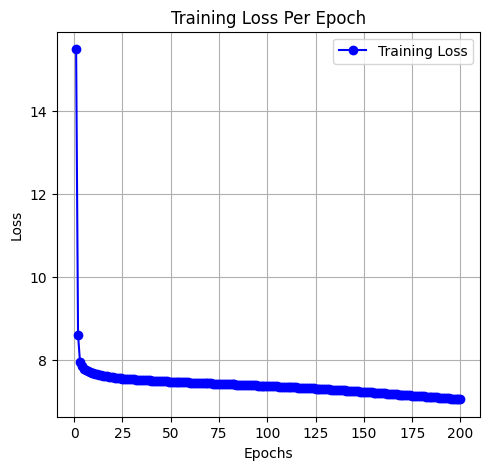

In [53]:

epochs = range(1, len(br_train_loss) + 1)  # Adjust epochs to match the length of train_loss

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, br_train_loss, label='Training Loss', marker='o', color='blue')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
# Set the model to evaluation mode
br.eval()

# Initialize variables to store the cumulative loss and count of samples processed
total_loss = 0.0
count = 0

# No gradient computations needed during testing
with torch.no_grad():
    for x, y in tqdm(test_loader_0, desc="Testing"):
        x, y = x.to(device), y.to(device)  # Ensure data is on the correct device

        # Forward pass: compute predictions
        pred = br(x)
        loss = loss_func(pred.squeeze(), y)  # Calculate loss, ensure dimensions match

        # Accumulate the total loss and the number of samples
        total_loss += loss.item() * x.size(0)
        count += x.size(0)

# Compute the average loss across all test data
average_loss = total_loss / count if count != 0 else 0

# Print the average loss for the testing phase
print(f"Average Test Loss: {average_loss:.4f}")


Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Average Test Loss: 7.1667


### Neural Network (LSTM encoder)

In [156]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional=False):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.feature_dim = hidden_dim * 2 if bidirectional else hidden_dim

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        # Ensure consistent dimensionality regardless of the batch size
        if hidden.dim() == 2:
            hidden = hidden.unsqueeze(0)  # Add a batch dimension if it's missing

        if self.lstm.bidirectional:
            # Concatenate the hidden states from both directions
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            # Get the last layer's last direction output
            hidden = hidden[-1]

        return hidden


In [157]:
class Regressor(nn.Module):
    def __init__(self, input_dim):
        super(Regressor, self).__init__()
        self.fc_b1 = nn.Linear(input_dim, 32)
        self.fc_b2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc_b1(x))
        x = self.fc_b2(x)
        return x


In [158]:

input_dim = 66  # Input dimensionality
hidden_dim = 64  # Hidden state dimensionality

# Initialize Encoder
encoder = Encoder(input_dim, hidden_dim).to(device)
# Initialize Regressor with encoder's feature_dim
regressor = Regressor(input_dim=encoder.feature_dim).to(device)



In [159]:

# Loss function
loss_func = nn.MSELoss()

# Optimizer
optimizer = optim.SGD(list(encoder.parameters()) + list(regressor.parameters()), lr=0.0001, momentum=0.9, weight_decay=5e-4)

num_epochs = 200


In [160]:

#training loop
train_loss = []
for epoch in range(1, num_epochs + 1):
    encoder.train()
    regressor.train()
    epoch_loss_list = []

    for x, y in train_loader_0:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        embedding = encoder(x)
        pred = regressor(embedding)

        loss = loss_func(pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss_list.append(loss.item())



    if len(epoch_loss_list) == 0:
        print("Warning: No data processed this epoch")
        average_loss = 0

    else:
        average_loss = sum(epoch_loss_list) / len(epoch_loss_list)


    train_loss.append(average_loss)


    print(f'Epoch {epoch}: Avg Loss = {average_loss:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([127])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: Avg Loss = 17.7693
Epoch 2: Avg Loss = 11.2800
Epoch 3: Avg Loss = 8.1512
Epoch 4: Avg Loss = 7.8857
Epoch 5: Avg Loss = 7.8916
Epoch 6: Avg Loss = 7.8896
Epoch 7: Avg Loss = 7.8891
Epoch 8: Avg Loss = 7.8808
Epoch 9: Avg Loss = 7.8850
Epoch 10: Avg Loss = 7.8700
Epoch 11: Avg Loss = 7.8780
Epoch 12: Avg Loss = 7.8896
Epoch 13: Avg Loss = 7.8841
Epoch 14: Avg Loss = 7.8754
Epoch 15: Avg Loss = 7.8817
Epoch 16: Avg Loss = 7.8748
Epoch 17: Avg Loss = 7.8773
Epoch 18: Avg Loss = 7.8828
Epoch 19: Avg Loss = 7.8770
Epoch 20: Avg Loss = 7.8855
Epoch 21: Avg Loss = 7.8750
Epoch 22: Avg Loss = 7.8826
Epoch 23: Avg Loss = 7.8835
Epoch 24: Avg Loss = 7.8865
Epoch 25: Avg Loss = 7.8808
Epoch 26: Avg Loss = 7.8832
Epoch 27: Avg Loss = 7.8798
Epoch 28: Avg Loss = 7.8799
Epoch 29: Avg Loss = 7.8788
Epoch 30: Avg Loss = 7.8750
Epoch 31: Avg Loss = 7.8770
Epoch 32: Avg Loss = 7.8804
Epoch 33: Avg Loss = 7.8865
Epoch 34: Avg Loss = 7.8733
Epoch 35: Avg Loss = 7.8788
Epoch 36: Avg Loss = 7.8643

In [161]:
batches_per_epoch = len(train_loader_0)
total_batches = num_epochs * batches_per_epoch
epochs = range(1, total_batches + 1)


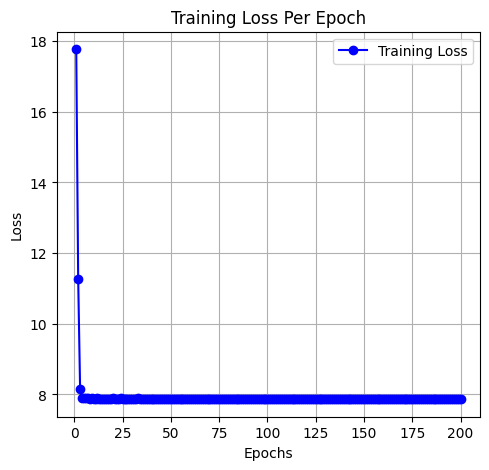

In [162]:

epochs = range(1, len(train_loss) + 1)  # Adjust epochs to match the length of train_loss

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='blue')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [165]:

test_loss = []


encoder.eval()
regressor.eval()

with torch.no_grad():
    for x, y in test_loader_0:
        x, y = x.to(device), y.to(device)

        embedding = encoder(x)
        pred = regressor(embedding)

        loss = loss_func(pred, y)
        test_loss.append(loss.item())

average_test_loss = sum(test_loss) / len(test_loss)


print(f'Test Results - Average Loss: {average_test_loss:.4f}')


Test Results - Average Loss: 7.7020


###NN combinded (linear+LSTM encoder)


In [ ]:

class CombinedEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional=False):
        super(CombinedEncoder, self).__init__()
        # Initialize BaseRegressor and Encoder
        self.base_regressor = BaseRegressor()
        self.encoder = Encoder(input_dim, hidden_dim, num_layers, bidirectional)
        self.final_regressor = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        output_base = self.base_regressor(x)
        output_encoder = self.encoder(x)
        summed_output = output_base + output_encoder
        final_output = self.final_regressor(summed_output)
        return final_output


In [ ]:
class Regressor(nn.Module):
    def __init__(self, input_dim):
        super(Regressor, self).__init__()
        self.fc_b1 = nn.Linear(input_dim, 32)
        self.fc_b2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc_b1(x))
        x = self.fc_b2(x) #no activation function here, allowing for unbounded output
        return x


In [ ]:
def regression_accuracy(output, target, threshold=0.1):
    """ Calculate "accuracy" for regression within a certain threshold percentage. """
    with torch.no_grad():
        # Calculate the absolute difference
        difference = torch.abs(output - target)
        # Check if the difference is within the threshold * target
        correct = (difference < threshold * torch.abs(target)).float()
        # Calculate accuracy as the mean of correct predictions
        accuracy = 100 * correct.mean()
    return accuracy.item()

# threshold percentage for "correctness"
threshold = 0.1

accuracy = regression_accuracy(pred, y0_train, threshold)
print(f'Regression Accuracy (within {threshold*100}%): {accuracy:.2f}%')


Regression Accuracy (within 10.0%): 8.43%


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CombinedEncoder(input_dim=65, hidden_dim=32, num_layers=1, bidirectional=False)
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


In [ ]:

from torch.utils.data import DataLoader, TensorDataset, random_split


features = np.random.randn(10000, 65)
targets = np.random.randn(10000)

features_tensor = torch.tensor(features, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)

dataset = TensorDataset(features_tensor, targets_tensor)


total_samples = features_tensor.size(0)
test_size = int(total_samples * 0.3)
train_size = total_samples - test_size

#  random_split to create training and testing datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define the DataLoaders for both training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [ ]:
num_epochs = 200
epoch_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader_0:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss

        loss.backward()  # Backward pass and optimize
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_accuracy += regression_accuracy(outputs, labels, threshold) * inputs.size(0)

    epoch_loss = running_loss / len(train_loader_0.dataset)
    epoch_accuracy = running_accuracy / len(train_loader_0.dataset)
    epoch_losses.append(epoch_loss)  # Append the epoch loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([127])) that is different to the input size (torch.Size([127, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/200, Loss: 20.3065, Accuracy: 0.00%
Epoch 2/200, Loss: 20.1856, Accuracy: 0.00%
Epoch 3/200, Loss: 20.1124, Accuracy: 0.00%
Epoch 4/200, Loss: 19.9541, Accuracy: 0.00%
Epoch 5/200, Loss: 19.9195, Accuracy: 0.00%
Epoch 6/200, Loss: 19.7830, Accuracy: 0.00%
Epoch 7/200, Loss: 19.7358, Accuracy: 0.00%
Epoch 8/200, Loss: 19.5081, Accuracy: 0.00%
Epoch 9/200, Loss: 19.2943, Accuracy: 0.00%
Epoch 10/200, Loss: 19.2289, Accuracy: 0.00%
Epoch 11/200, Loss: 19.1909, Accuracy: 0.00%
Epoch 12/200, Loss: 19.1566, Accuracy: 0.00%
Epoch 13/200, Loss: 18.8217, Accuracy: 0.00%
Epoch 14/200, Loss: 18.8083, Accuracy: 0.00%
Epoch 15/200, Loss: 18.5904, Accuracy: 0.00%
Epoch 16/200, Loss: 18.4437, Accuracy: 0.00%
Epoch 17/200, Loss: 18.1767, Accuracy: 0.00%
Epoch 18/200, Loss: 17.8963, Accuracy: 0.00%
Epoch 19/200, Loss: 17.6862, Accuracy: 0.00%
Epoch 20/200, Loss: 17.4013, Accuracy: 0.00%
Epoch 21/200, Loss: 17.2881, Accuracy: 0.00%
Epoch 22/200, Loss: 16.8160, Accuracy: 0.10%
Epoch 23/200, Loss:

In [ ]:
model.eval()
test_loss = 0.0
test_accuracy = 0.0

with torch.no_grad():
    for inputs, labels in test_loader_0:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss


        test_loss += loss.item() * inputs.size(0)
        test_accuracy += regression_accuracy(outputs, labels, threshold) * inputs.size(0)

# Calculate average loss and accuracy over the testing dataset
test_loss /= len(test_loader_0.dataset)
test_accuracy /= len(test_loader_0.dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 7.7070, Test Accuracy: 8.57%


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


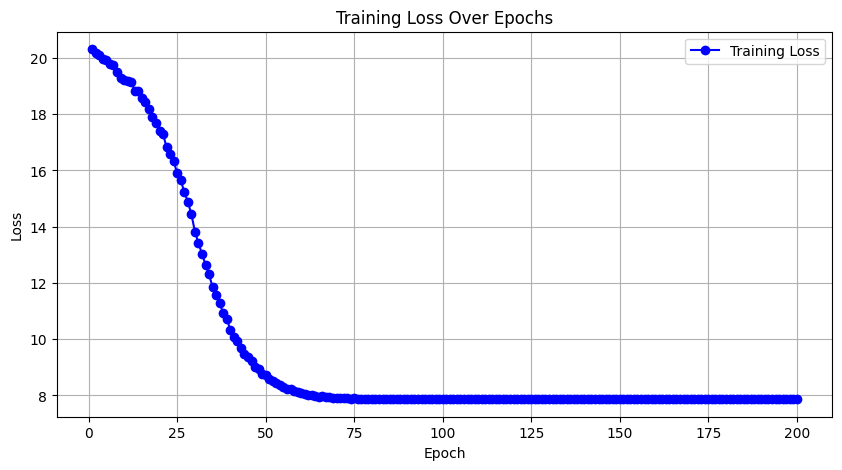

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
